In [42]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
import matplotlib.pyplot as plt
import os

## Utility function to extract features from wav files

* Pre-process data and transform double channel to single channel
* Extract the chromagraph  from the audio file
* Find note frequency

In [43]:
def preProcess( fileName ):
    
    # Extracting wav file data
    [Fs, x] = audioBasicIO.readAudioFile(fileName);

    # If double channel data then take mean
    if( len( x.shape ) > 1 and  x.shape[1] == 2 ):
        x = np.mean( x, axis = 1, keepdims = True )
    else:
        x = x.reshape( x.shape[0], 1 )
    
    # Extract the raw chromagram data, expected dimention is [ m,  ] not [ m, 1 ]
    F, f_names = audioFeatureExtraction.stFeatureExtraction(
        x[ :, 0 ], 
        Fs, 0.050*Fs, 
        0.025*Fs
    )
    
    return (f_names, F)

In [44]:
def getChromagram( audioData ):
    
    # chronograph_1
    temp_data =  audioData[ 21 ].reshape( 1, audioData[ 21 ].shape[0] )
    chronograph = temp_data
    
    # looping through the next 11 stacking them vertically
    for i in range( 22, 33 ):
        temp_data =  audioData[ i ].reshape( 1, audioData[ i ].shape[0] )
        chronograph = np.vstack( [ chronograph,  temp_data ] )
    
    return chronograph

In [58]:
def getNoteFrequency( chromagram ):
    
    # Total number of time frames in the current sample
    numberOfWindows = chromagram.shape[1]
    
    # Taking the note with the highest amplitude
    freqVal = chromagram.argmax( axis = 0 )
    
    # Converting the freqVal vs time to freq count
    histogram, bin = np.histogram( freqVal, bins = 12 ) 
    
    # Normalizing the distribution by the number of time frames
    normalized_hist = histogram.reshape( 1, 12 ).astype( float ) / numberOfWindows
    
    return normalized_hist

## Utility function to plot a heat map and frequency of each note

In [46]:
def plotHeatmap( chromagraph, smallSample = True ):
    
    notesLabels = [ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]
    
    fig, axis = plt.subplots()
    
    if smallSample:
        im = axis.imshow( chromagram[ :, 0 : 25 ], cmap = "YlGn" )
    else:
        im = axis.imshow( chromagram )
        
    cbar = axis.figure.colorbar(im, ax = axis,  cmap = "YlGn")
    cbar.ax.set_ylabel("Amplitude", rotation=-90, va="bottom")
    
    axis.set_yticks( np.arange( len(notesLabels) ) )
    axis.set_yticklabels(notesLabels)
    
    axis.set_title( "chromagram" )
    
    fig.tight_layout()
    _ = plt.show()

In [47]:
def noteFrequencyPlot( noteFrequency, smallSample = True ):
    
    fig, axis = plt.subplots(1, 1, sharey=True )
    
    axis.plot( np.arange( 1, 13 ), noteFrequency[0, :] )
    
    _ = plt.show()

## Running sample data on defined functions

In [48]:
feature_name, features = preProcess( "./sample_data_audio/couchplayin.wav" )

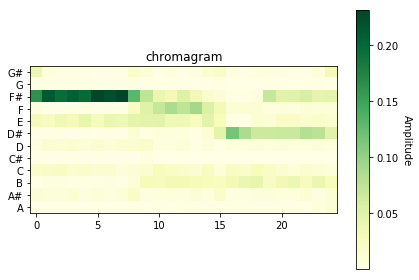

In [49]:
chromagram = getChromagram( features )
plotHeatmap( chromagram )

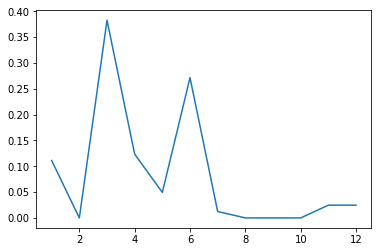

In [50]:
noteFrequency = getNoteFrequency( chromagram )
noteFrequencyPlot( noteFrequency )

## Dataset  generator
This function iterates over all the available files and converts them into note frequency arrays which is out feature set for each audio file.

In [51]:
fileList = []

def getDataset( filePath ):
    X = pd.DataFrame(  )
    
    columns=[ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]
    
    for root, dirs, filenames in os.walk( filePath ):
        for file in filenames:
            fileList.append( file )
            feature_name, features = preProcess(filePath + file )
            chromagram = getChromagram( features )
            noteFrequency = getNoteFrequency( chromagram )
            x_new =  pd.Series(noteFrequency[ 0, : ])
            X = pd.concat( [ X, x_new ], axis = 1 )
        
    data = X.T.copy()
    data.columns = columns
    data.index = [ i for i in range( 0, data.shape[ 0 ] ) ]
            
    return data

In [52]:
data = getDataset( "./sample_data_audio/" )

## A peek into the dataset

Each row represents a file and each column represents the frequency distribution of notes

In my case, I have 19 files in total.

In [53]:
data

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A
0,0.111111,0.000000,0.382716,0.123457,0.049383,0.271605,0.012346,0.000000,0.000000,0.000000,0.024691,0.024691
1,0.408163,0.000000,0.000000,0.224490,0.000000,0.000000,0.306122,0.000000,0.000000,0.000000,0.000000,0.061224
2,0.315789,0.556391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127820
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.017341,0.000000,0.000000,0.566474,0.000000,0.000000,0.046243,0.005780,0.000000,0.000000,0.335260,0.028902
5,0.944444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556
6,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000
7,0.051546,0.000000,0.247423,0.474227,0.000000,0.000000,0.020619,0.082474,0.010309,0.020619,0.051546,0.041237
8,0.863636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364
9,0.053571,0.142857,0.053571,0.000000,0.053571,0.535714,0.000000,0.000000,0.000000,0.107143,0.017857,0.035714


### Hyper-parameters

In [54]:
# Number of cluster we wish to divide the data into( user tunable )
k = 4

# Max number of allowed iterations for the algorithm( user tunable )
epochs = 1000

### K-means utility functions

In [59]:
def initilizeCentroids( data, k ):
    '''
    Initilize cluster centroids( assuming first k data points to be centroid return them )
    '''
    centroids = data[ 0: k ]
    return centroids

In [60]:
X = tf.placeholder( dtype = tf.float32 )
C = tf.placeholder( dtype = tf.float32 )
C_labels = tf.placeholder( dtype = tf.int32 )

# utility to assign centroids to examples
expanded_vectors = tf.expand_dims( X, 0 )
expanded_centroids = tf.expand_dims( C, 1 )
distance = tf.reduce_sum( tf.square( tf.subtract( expanded_vectors, expanded_centroids ) ), axis = 2 )
getCentroidsOp = tf.argmin( distance, 0 )


# utility to recalculate centroids
sums = tf.unsorted_segment_sum( X, C_labels, k )
counts = tf.unsorted_segment_sum( tf.ones_like( X ), C_labels, k  )
reCalculateCentroidsOp = tf.divide( sums,  counts )

### Driver function

In [63]:
centroids = []
data_labels = []

with tf.Session() as sess:
    
    # Initilize all tensor flow variables
    sess.run( tf.global_variables_initializer() )
    
    # Get initial list of k centroids
    centroids = initilizeCentroids( data, k )
    
    for epoch in range( epochs ):
        data_labels =  sess.run( getCentroidsOp, feed_dict = { X: data, C: centroids } )
        centroids = sess.run( reCalculateCentroidsOp, feed_dict = { X: data, C_labels: data_labels } )
    
print( data_labels )
print( centroids )

[0 1 2 3 0 1 1 0 1 0 1 1 0 3 1 3 0 1 1]
[[0.05502984 0.0310559  0.1308599  0.20368809 0.15583807 0.1345532
  0.01320117 0.03403277 0.00171821 0.04544815 0.13919203 0.05538265]
 [0.450697   0.00441501 0.         0.02494331 0.         0.
  0.04734694 0.         0.         0.02693603 0.02693603 0.4187257 ]
 [0.31578946 0.556391   0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.12781955]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.        ]]


In [64]:
final_labels = pd.DataFrame( { "Labels": data_labels, "File Names": fileList } )
final_labels

,File Names,Labels
0,couchplayin.wav,0
1,Bass-Drum-1.wav,1
2,Ensoniq-ESQ-1-Synth-Voice-C5.wav,2
3,Casio-CZ-5000-Human-Voice-C4.wav,3
4,Yamaha-TG500-CH-Aah-C3.wav,0
5,Boom-Kick.wav,1
6,Hi-Bongo.wav,1
7,Roland-R-8-Crash-Cymbal.wav,0
8,Deep-Kick.wav,1
9,Crash-Cymbal-2.wav,0
